In [173]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from keras.layers import Dropout, BatchNormalization, Bidirectional, LSTM, MultiHeadAttention, Dense, Input, Concatenate, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model

In [174]:
seed = 0
tf.random.set_seed(seed)

In [175]:
train = pd.read_csv(r'C:\Users\Admin\Network Intrustion Detection\dataset\train.csv')
val = pd.read_csv(r'C:\Users\Admin\Network Intrustion Detection\dataset\val.csv')
test  = pd.read_csv(r'C:\Users\Admin\Network Intrustion Detection\dataset\test.csv')

In [176]:
X_train = train.drop('Label', axis=1)
y_train = train['Label']
X_test = test.drop('Label', axis=1)
y_test = test['Label']
X_val = val.drop('Label', axis=1)
y_val = val['Label']

In [177]:
X_train_numeric = pd.get_dummies(X_train, drop_first=True)
X_val_numeric = pd.get_dummies(X_val, drop_first=True)
X_test_numeric = pd.get_dummies(X_test, drop_first=True)

In [178]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_numeric), columns=X_val_numeric.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_numeric), columns=X_test_numeric.columns)

In [179]:
X_train_scaled_tensor = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled_tensor = X_val_scaled.values.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled_tensor = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [180]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [195]:
def Build_model(X_train, y_train, X_val, y_val, X_test, y_test, optimizer,
                n_of_hidden_layers, n_neurons, activation='tanh', dropout_rate=0.3, epochs=50, batch_size=128, early_stopping=True, verbose=1):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = inputs
    
    # Adding Bidirectional LSTM layers with Dropout and BatchNormalization
    for _ in range(n_of_hidden_layers):
        x = Bidirectional(LSTM(n_neurons, activation=activation, return_sequences=True))(x)
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x)
    
    attention = MultiHeadAttention(num_heads=4, key_dim=n_neurons)(x, x)
    x = Concatenate()([x, attention])
    
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    
    outputs = Dense(6, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    es = EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    if early_stopping:
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)
    else:
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    train_evaluation = model.evaluate(X_train, y_train, verbose=0)
    test_evaluation = model.evaluate(X_test, y_test, verbose=0)
    validation_evaluation = model.evaluate(X_val, y_val, verbose=0)
    
    return model, history, train_evaluation, validation_evaluation, test_evaluation

In [196]:
def Build_experiment(X_train, y_train, X_val, y_val, X_test, y_test,
                     n_of_hidden_layers, n_neurons, activation='tanh', dropout_rate=0.3, epochs=50, batch_size=128, n_of_models=5, early_stopping=True, verbose=1):
    models_dict = {'models': [], 'history': []}

    models_train_acc = []
    models_test_acc = []
    models_valid_acc = []

    for j in range(n_of_models):
        # Recreate optimizer for each model
        optimizer = Adam(learning_rate=0.001)
        
        # Build model
        model, history, train_evaluation, valid_evaluation, test_evaluation = Build_model(
            X_train, y_train, X_val, y_val, X_test, y_test, optimizer,
            n_of_hidden_layers, n_neurons, activation=activation, dropout_rate=dropout_rate, epochs=epochs, batch_size=batch_size, early_stopping=early_stopping, verbose=verbose
        )
        
        # Save data
        models_train_acc.append(train_evaluation[1])
        models_test_acc.append(test_evaluation[1])
        models_valid_acc.append(valid_evaluation[1])

        models_dict['models'].append(model)
        models_dict['history'].append(history)

    accuracies_dict = {
        "Min_train_acc": min(models_train_acc),
        "Max_train_acc": max(models_train_acc),
        "AVG_train_acc": np.mean(models_train_acc),
        "Min_test_acc": min(models_test_acc),
        "Max_test_acc": max(models_test_acc),
        "AVG_test_acc": np.mean(models_test_acc),
        "Min_valid_acc": min(models_valid_acc),
        "Max_valid_acc": max(models_valid_acc),
        "AVG_valid_acc": np.mean(models_valid_acc)
    }

    return accuracies_dict, models_dict, models_train_acc, models_test_acc, models_valid_acc

In [200]:
# Perform cross-validation
def cross_validate(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold = 1
    all_train_acc = []
    all_val_acc = []

    for train_index, val_index in kf.split(X):
        print(f"Training on fold {fold}...")
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        _, model_dict, train_acc, val_acc, _ = Build_experiment(
            X_train_fold, y_train_fold, X_val_fold, y_val_fold, X_val_fold, y_val_fold,
            n_of_hidden_layers=2, n_neurons=50, activation='tanh', dropout_rate=0.3, epochs=50, batch_size=128, n_of_models=1, early_stopping=True, verbose=1
        )
        
        all_train_acc.append(train_acc[0])  # Each fold has one model with one accuracy value
        all_val_acc.append(val_acc[0])
        fold += 1

    return all_train_acc, all_val_acc

# Convert tensors back to arrays for cross-validation
X_combined = np.vstack([X_train_scaled_tensor, X_val_scaled_tensor, X_test_scaled_tensor])
y_combined = np.hstack([y_train_encoded, y_val_encoded, y_test_encoded])

# Perform cross-validation
train_acc, val_acc = cross_validate(X_combined, y_combined)

Training on fold 1...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3472 - loss: 1.6282 - val_accuracy: 0.3979 - val_loss: 1.6262
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5794 - loss: 0.9344 - val_accuracy: 0.4793 - val_loss: 1.5319
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6243 - loss: 0.8378 - val_accuracy: 0.4980 - val_loss: 1.4585
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6317 - loss: 0.8007 - val_accuracy: 0.5621 - val_loss: 1.3753
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6701 - loss: 0.7482 - val_accuracy: 0.5821 - val_loss: 1.2857
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6593 - loss: 0.7467 - val_accuracy: 0.6115 - val_loss: 1.2190
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6677 - loss: 0.7217 - val_accuracy: 0.6796 - val_loss: 1.1312
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6952 - loss: 0.6930 - va

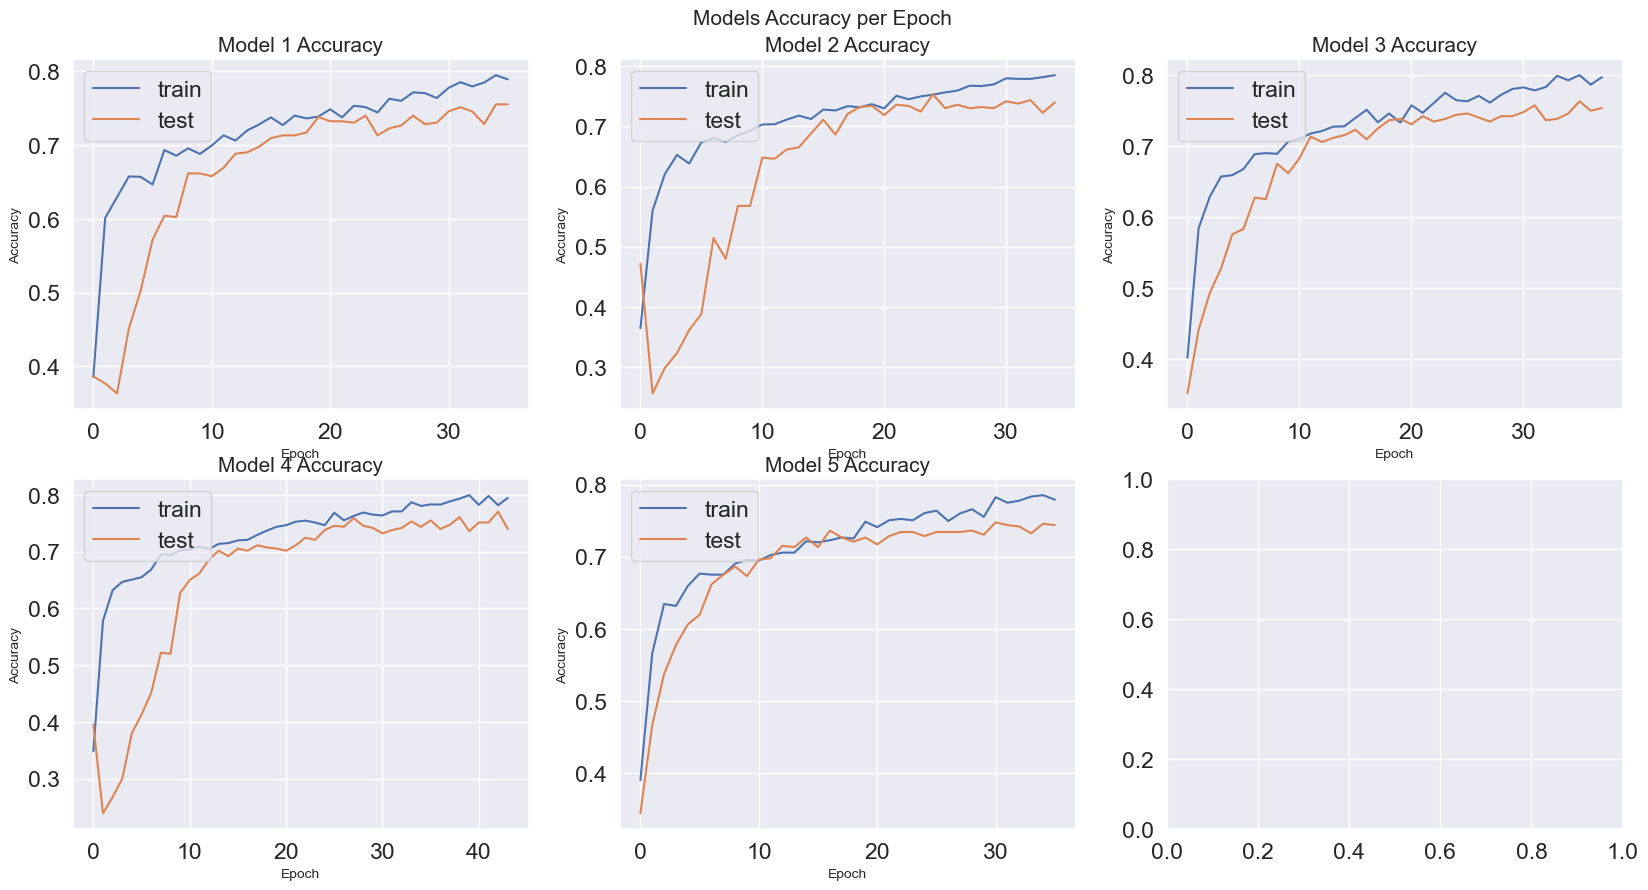

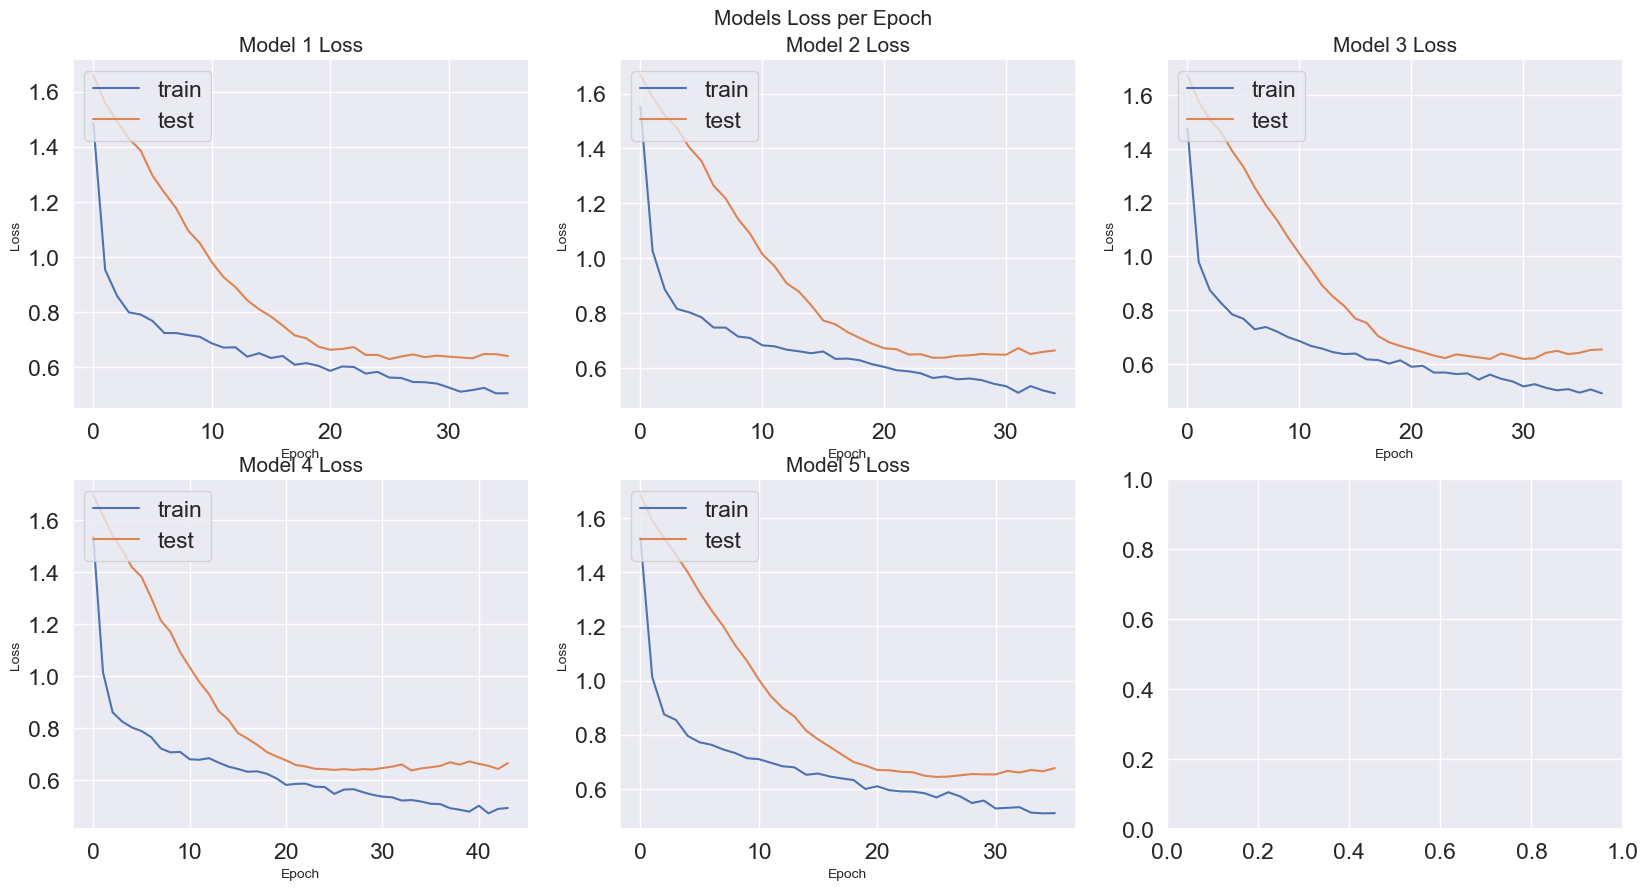

In [201]:
def plot_history(dict_of_lists, type='loss'):
    axis_idx = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for i in range(len(dict_of_lists)):
        ax = axes[axis_idx[i][0]][axis_idx[i][1]]
        # Summarize history for accuracy
        ax.plot(dict_of_lists[i].history[type])
        ax.plot(dict_of_lists[i].history[f'val_{type}'])
        ax.set_title(f'Model {i+1} {type.title()}', size=15)
        ax.set_ylabel(f'{type.title()}', size=10)
        ax.set_xlabel('Epoch', size=10)
        ax.legend(['train', 'test'], loc='upper left')
    plt.suptitle(f'Models {type.title()} per Epoch', size=15, y=0.93)
    plt.show()

plot_history(lstm_models_dict['history'], type='accuracy')
plot_history(lstm_models_dict['history'], type='loss')

 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step

E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
 1/18 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step

E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step

E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 

E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step

E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step

E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


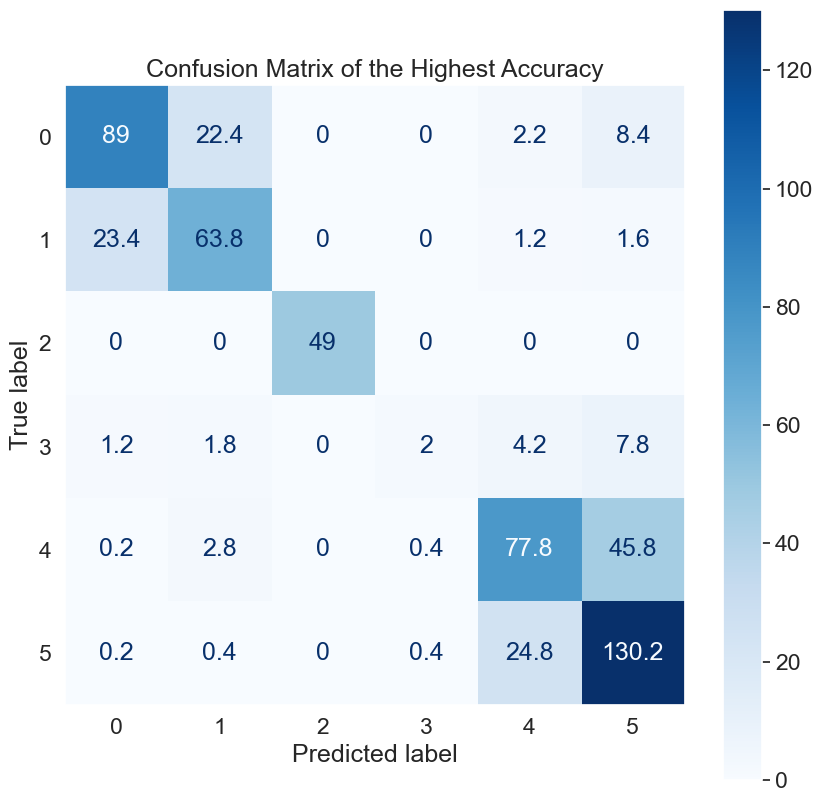

In [186]:
# Display the average confusion matrix
cm = np.zeros(shape=(6, 6))
for model in lstm_models_dict['models']:
    pred = model.predict(X_test_scaled_tensor).argmax(axis=1)
    cm += confusion_matrix(y_test_encoded, pred)
cm_avg = cm / len(lstm_models_dict['models'])

# Set custom color palette
colors = ["#FF0B04", "#4374B3"]
sns.set_palette(sns.color_palette(colors))
sns.set(font_scale=1.5)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')

fig = disp.ax_.get_figure()
fig.set_figwidth(10)
fig.set_figheight(10)

plt.title('Confusion Matrix of the Highest Accuracy')
plt.grid(False)
plt.show()

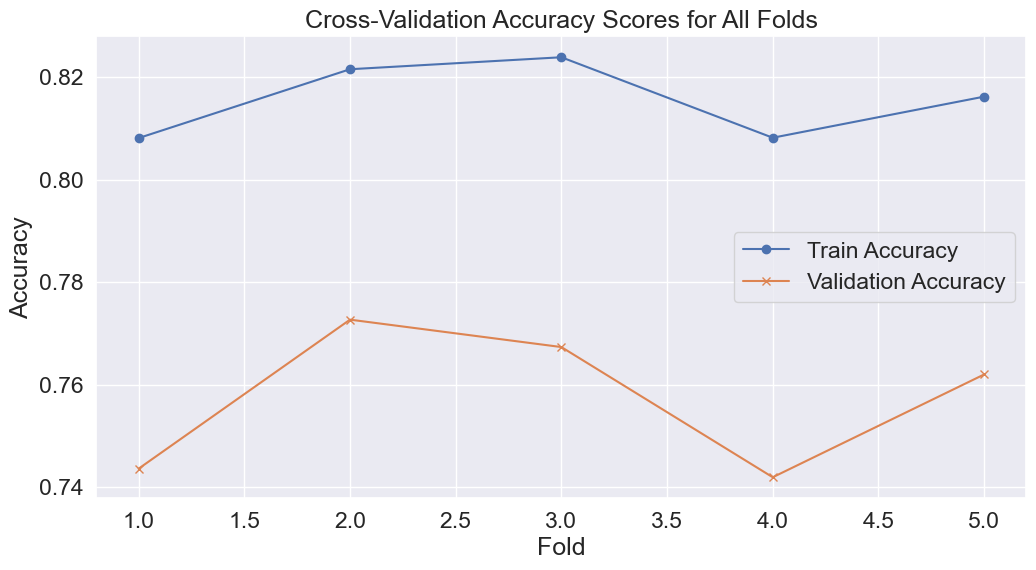

In [203]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, marker='x', label='Validation Accuracy')

plt.title('Cross-Validation Accuracy Scores for All Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [205]:
print("Average Train Accuracy:", lstm_accuracies_dict.get("AVG_train_acc", "N/A"))
print("Average Validation Accuracy:", lstm_accuracies_dict.get("AVG_valid_acc", "N/A"))
print("Average Test Accuracy:", lstm_accuracies_dict.get("AVG_test_acc", "N/A"))


Average Train Accuracy: 0.8077513909339906
Average Validation Accuracy: 0.7269998383522033
Average Test Accuracy: N/A


In [192]:
Average Train Accuracy: 0.8058037400245667
Average Validation Accuracy: 0.7764705777168274
Average Test Accuracy: 0.7604277968406677

SyntaxError: invalid syntax (2451125004.py, line 1)

In [162]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

X = X_train_scaled_tensor
y = y_train_encoded

train_accuracies = []
val_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    model = Build_model(input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]))

    es = EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, verbose=1
    )

    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=128, callbacks=[es, lr_scheduler], verbose=1)
    
    train_acc = model.evaluate(X_train_fold, y_train_fold, verbose=0)[1]
    val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

Epoch 1/50


E:\Anaconda\envs\deepfake_detection\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.2892 - loss: 1.7170 - val_accuracy: 0.3760 - val_loss: 1.6796 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5641 - loss: 1.0224 - val_accuracy: 0.4027 - val_loss: 1.5547 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6121 - loss: 0.8964 - val_accuracy: 0.4733 - val_loss: 1.4845 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6299 - loss: 0.8326 - val_accuracy: 0.5229 - val_loss: 1.4360 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6328 - loss: 0.8182 - val_accuracy: 0.5324 - val_loss: 1.3915 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6768 - loss: 0.7768 - val_accuracy: 0.5573 - val_loss: 1.3278 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6574 - loss: 0.7794 - val_accuracy: 0.5802 - v

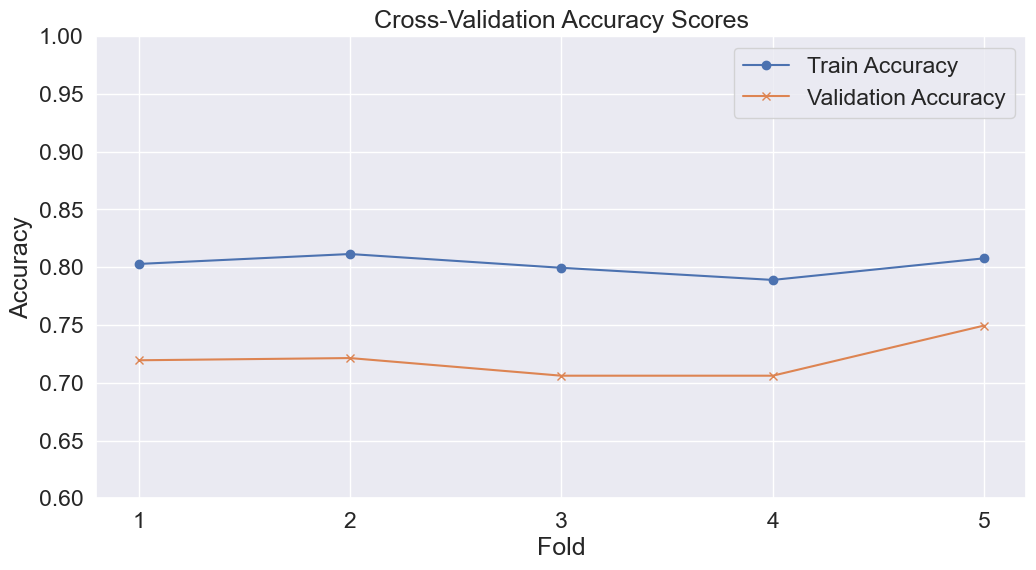

Train Accuracies:  [0.8028639554977417, 0.8114558458328247, 0.7995226979255676, 0.7890214920043945, 0.8077290058135986]
Validation Accuracies:  [0.7194656729698181, 0.7213740348815918, 0.7061068415641785, 0.7061068415641785, 0.7495219707489014]
Average Train Accuracy:  0.8021185994148254
Average Validation Accuracy:  0.7205150723457336


In [163]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_splits + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, n_splits + 1), val_accuracies, marker='x', label='Validation Accuracy')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1.0)
plt.xticks(range(1, n_splits + 1))
plt.legend()
plt.grid(True)
plt.show()

print("Train Accuracies: ", train_accuracies)
print("Validation Accuracies: ", val_accuracies)
print("Average Train Accuracy: ", np.mean(train_accuracies))
print("Average Validation Accuracy: ", np.mean(val_accuracies))